In [9]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Engine

## Exponential function

In [2]:
def pexp(lambda_, x):
    """ PDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the x value of the distribution. Intuitively,
        for example the time that has passed since the previous event

    Returns:
        float: the probability density at that x. Intuitively,
        for example the probability of having an event at time x
    """
    return lambda_* np.exp(-lambda_ * x)

def dexp(lambda_, x):
    """ CDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the x value of the distribution. Intuitively,
        for example the time that has passed since the previous event

    Returns:
        float: the cumulative probability of all values between 0 and x,
        inclusive. 
        Intuitively, for example the probability of having an event 
        at any time before and including x
    """
    return -1 * np.exp(-lambda_ * x)

def rexp(lambda_):
    """ Draw values from the exponential distribution
    This will be done through the Inverse Transform sampling Method.
    So we want to find a number x for which FX(x) = U; where X is a 
    random variable (exponential variable in this case) and U is a 
    uniform random variable and FX its distribution function 
    (exponential distribution in this case). So this means that to find x
    (the goal of this whole function) we need to solve for x = F^(-1)_x(U).
    
    So the steps are:
    - calculate the inverse of the exponential CDF: F^(-1)_x
    - draw a uniform random probability U (from the interval [0,1], of course)
    - calculate x = F^(-1)_x(U)

    Args:
        lambda_ (int): the rate

    Returns:
        float: a random exponential variable
    """
    u = np.random.uniform(low=0, high=1, size=1)
    t = (-1/lambda_) * np.log(u)
    return t.item()

## Test exponential random variable generation

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.26102504628613077, pvalue=1.3389744970669008e-60, statistic_location=1.0907186643156108, statistic_sign=-1)

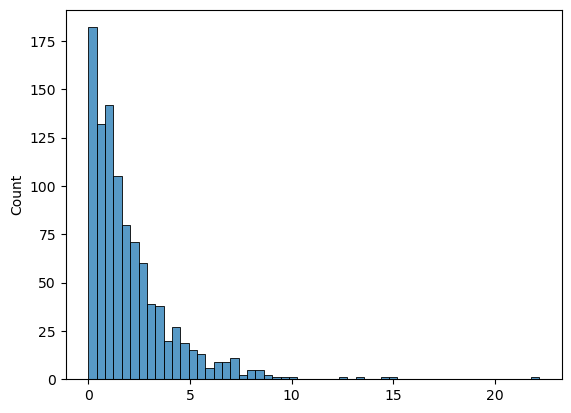

In [24]:
to_test = [rexp(0.5) for i in range(1000)]
sns.histplot(to_test)
stats.kstest(to_test, "expon")

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.047, pvalue=0.21939649929677082, statistic_location=1.110624173968146, statistic_sign=-1)

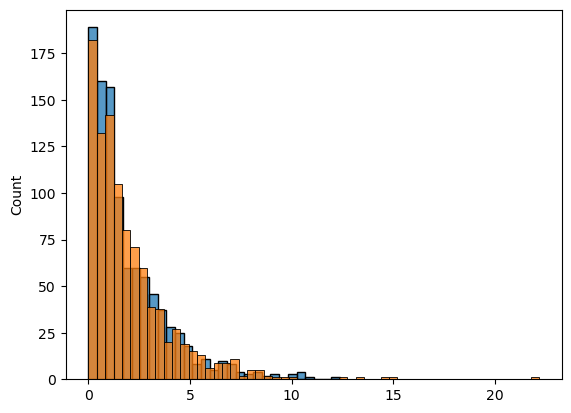

In [28]:
r = stats.expon.rvs(size=1000, scale=1/0.5)
sns.histplot(r)
sns.histplot(to_test)
stats.kstest(to_test, r)

## Simulation engine

In [3]:
def gillespie_simulation(L, T, LT, k_bind, k_dissociate, t_vec, cycles, steps):
    for i in range(cycles):
        for j in range(steps):
            # Calculate partial reaction rates
            r_bind = k_bind * L[i, j] * T[i, j]
            r_dissociate = k_dissociate * LT[i, j]

            # Calculate global reaction rate
            r_total = r_bind + r_dissociate

            # Calculate probabilities of each reaction
            p_LT = r_bind / r_total
            # p_L_T = r_dissociate / r_total  # only one of these 2 are needed

            # Calculate time to next reaction
            time_next_reaction = rexp(lambda_=r_total)
            t_vec[i, j+1] = t_vec[i, j] + time_next_reaction
            
            # Select which reaction occured
            # Note: This is applying the direct method, but with only 2 reactions
            # Can be extended to X reactions by sampling from a r_i/r_total distribution
            u = np.random.uniform(low=0, high=1, size=1)
            
            # Another alternative is the First-reaction method in which
            # we draw 2 exponential variables (time), each with r_i parameter instead of
            # r_total and select the time and reaction with the smallest time.
            # This is shown to be equivalent as the above

            if u < p_LT:
                L[i, j+1] = L[i, j] - 1
                T[i, j+1] = T[i, j] - 1
                LT[i, j+1] = LT[i, j] + 1
            else:
                L[i, j+1] = L[i, j] + 1
                T[i, j+1] = T[i, j] + 1
                LT[i, j+1] = LT[i, j] - 1
                
    return L, T, LT, t_vec


# Simulate with physiological constants

In [52]:
# Fix model parameters
k_bind = 0.0146
k_dissociate = 35

L0 = 10000
T0 = 7000
LT0 = 0

steps = 10000    # Number of reactions per trajectory
cycles = 100  # Number of trajectories iterated over

# Set up holder arrays
t = np.zeros((cycles, steps+1))
L = np.zeros((cycles, steps+1))
T = np.zeros((cycles, steps+1))
LT = np.zeros((cycles, steps+1))

# Store initial conditions
L[:, 0] = L0
T[:, 0] = T0
LT[:, 0] = LT0


In [53]:
L, T, LT, t = gillespie_simulation(L=L, T=T, LT=LT, k_bind=k_bind, k_dissociate=k_dissociate, t_vec=t, cycles=cycles, steps=steps)

# Plot Average trajectory

In [54]:
ave_steps = 100
t_max = t.max()

# Set up average arrays
t_ave = np.linspace(0,t_max,ave_steps+1)
L_ave = np.zeros(ave_steps+1)
T_ave = np.zeros(ave_steps+1)
LT_ave = np.zeros(ave_steps+1)

L_ave[0] = L0
T_ave[0] = T0
LT_ave[0] = LT0

# Pass over average array entries
for i in range(1, ave_steps+1):
    tmax = t_ave[i]
    A_sum = 0
    B_sum = 0
    AB_sum = 0
    t_count = 0
    
    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if t[j,k] <= tmax and t[j,k+1] > tmax:
                t_count += 1
                A_sum += L[j,k]
                B_sum += T[j,k]
                AB_sum += LT[j,k]
    
    # Calculate average - taking care if no samples observed
    if t_count == 0:
        L_ave[i] = L_ave[i-1]
        T_ave[i] = T_ave[i-1]
        LT_ave[i] = LT_ave[i-1]
    else:
        L_ave[i] = A_sum / t_count
        T_ave[i] = B_sum / t_count
        LT_ave[i] = AB_sum / t_count

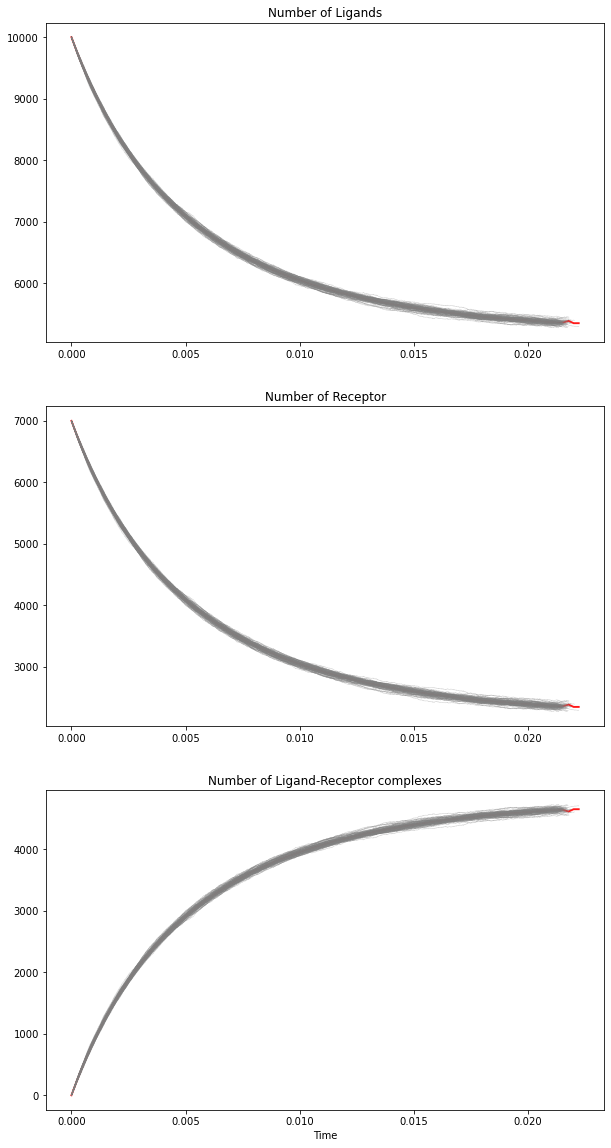

In [63]:
###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

# Plot average trajectories
axs[0].plot(t_ave, L_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Ligands')

axs[1].plot(t_ave, T_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Receptor')

axs[2].plot(t_ave, LT_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Ligand-Receptor complexes')
axs[2].set_xlabel("Time")

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(t[i,:], L[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(t[i,:], T[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(t[i,:], LT[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

# Snapshot of molecule distribution of each type at a certain time

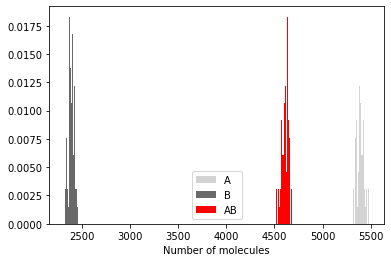

In [74]:
time = 0.02
L_time = np.zeros(cycles)
T_time = np.zeros(cycles)
LT_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if t[i,j] >= time and t[i,j-1] < time:
            L_time[i] = L[i,j]
            T_time[i] = T[i,j]
            LT_time[i] = LT[i,j]
    # If trajectory doesn't span far enough take latest observation
    if t[i, steps] < time:
        L_time[i] = L[i, steps]
        T_time[i] = T[i, steps]
        LT_time[i] = LT[i, steps]

plt.hist(L_time, density=True, bins=int(cycles/4), label="A", color='lightgrey')
plt.hist(T_time, density=True, bins=int(cycles/4), label="B", color='dimgrey')
plt.hist(LT_time, density=True, bins=int(cycles/4), label="AB", color='red')
plt.xlabel("Number of molecules")
plt.legend();

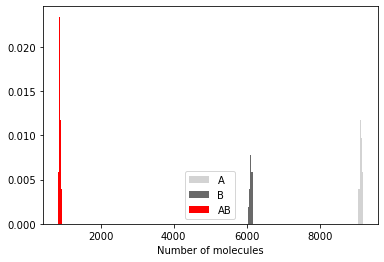

In [73]:
time = 0.001
L_time = np.zeros(cycles)
T_time = np.zeros(cycles)
LT_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if t[i,j] >= time and t[i,j-1] < time:
            L_time[i] = L[i,j]
            T_time[i] = T[i,j]
            LT_time[i] = LT[i,j]
    # If trajectory doesn't span far enough take latest observation
    if t[i, steps] < time:
        L_time[i] = L[i, steps]
        T_time[i] = T[i, steps]
        LT_time[i] = LT[i, steps]

plt.hist(L_time, density=True, bins=int(cycles/4), label="A", color='lightgrey')
plt.hist(T_time, density=True, bins=int(cycles/4), label="B", color='dimgrey')
plt.hist(LT_time, density=True, bins=int(cycles/4), label="AB", color='red')
plt.xlabel("Number of molecules")
plt.legend();